# Exercício 3

O aluno irá escolher uma tarefa para resolver de maneira zero ou few-shot. Sugestões:
- Classificação de textos (ex: análise de sentimos (IMDB))
- Predizer se uma passagem/parágrafo é relevante para uma pergunta/query
- Se uma resposta predita por um sistema de QA ou sumarizador é semanticamente igual à resposta ground-truth


É importante ter uma função de avaliação da qualidade das respostas do modelo few-shot. Por exemplo, acurácia.


É possível criar um pequeno dataset de teste manualmente (ex: com 10 à 100 exemplos) 


- Usar a API do LLAMA fornecida por nós (licença exclusiva para pesquisa). Colab demo da API do LLAMA (obrigado, Thales Rogério)
- Opcionalmente, usar a API do code-davinci-002, que é de graça e trás resultados muito bons.
CUIDADO: NÃO USAR O TEXT-DAVINCI-002/003, que é pago



## Instalação de Pacotes

In [ ]:
# !pip install transformers -q
# !pip install datasets -q
# !pip install pyserini -q
# !pip install faiss-cpu -q
# !pip install optuna -q
# !pip install openai

In [103]:
### Used only to run on Google Colab
# from google.colab import drive
# drive.mount('/content/gdrive')

# Change de path to your drive
# base_path = "gdrive/MyDrive/Colab_Notebooks/P_IA368DD_2023S1/Exercicio3/"
base_path = ""
target_names = ["Negative", "Positive"]

In [149]:
import pandas as pd
import requests
from requests import JSONDecodeError
import json
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.auto import tqdm
import openai
import os
import pickle
import seaborn as sns

In [4]:
base_url="http://143.106.167.108/api"
openai.api_key = os.environ["API_KEY"]

## Funções do projeto

In [38]:
def load_data():
    df_data = pd.read_csv(f"{base_path}data/movie.csv")

    _, df_data = train_test_split(
        df_data,
        test_size=0.00125,
        stratify=df_data["label"],
        random_state=42
    )

    return df_data

df_data = load_data()

In [39]:
df_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 22606 to 36085
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50 non-null     object
 1   label   50 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


In [58]:
def read_responses_zero_shot_llama(response):
    request_uuid = response["request_uuid"]
    ready = False
    while not ready:
        r = requests.get(f"{base_url}/get_result/{request_uuid}")
        try:
            response = r.json()
            ready = response['ready']

            if ready:
                print(f"Response for {request_uuid} is ready!")
                answer = response["generated_text"].split('\n')[0]
                label = answer.split(" ")[0]

                answer = {
                    "generated_text": response['generated_text'],
                    "label": label
                }

                break

            # Wait 10 seconds before checking again
            time.sleep(10)
        except JSONDecodeError as ex:
            time.sleep(2)
            print(f"Trying {request_uuid} again!")

    return answer

In [57]:
def classify_zero_shot_llama():
    responses = []
    for index, row in tqdm(df_data.iterrows(), total=df_data.shape[0]):
        text = row["text"]

        data = {
            "prompt": """Answer with one word if the movie review is positive or negative

        review: {}
        output: """,
            "temperature": 0.0,
            "top_p": 1,
            "max_length": 250
        }

        data['prompt'] = data['prompt'].format(text)

        req = requests.post(f"{base_url}/complete", json=data)

        if req.ok:
            response = req.json()
            answer = read_responses_zero_shot_llama(response)
            responses.append(answer)

            with open(f'{base_path}data/responses_llama_zero.pickle', 'wb') as f:
                pickle.dump(responses, f)

    return responses

In [104]:
def show_results_llama_zero():
    with open(f'{base_path}data/responses_llama_zero.pickle', 'rb') as f:
        responses_llama_zero = pickle.load(f)
        
    preds = []
    for answer in responses_llama_zero:
        label = int(answer["label"])
        preds.append(label if label < 2 else 0)

    labels = df_data["label"].values
    
    print(classification_report(labels, preds, target_names=target_names))
    
    ax = sns.heatmap(confusion_matrix(labels, preds), cmap='Greens_r', annot=True, fmt='d')
    _ = ax.set(xlabel='Predicted', ylabel='Truth', title='Confusion Matrix')

In [100]:
responses = classify_zero_shot_llama()

              precision    recall  f1-score   support

    Negative       0.78      0.72      0.75        25
    Positive       0.74      0.80      0.77        25

    accuracy                           0.76        50
   macro avg       0.76      0.76      0.76        50
weighted avg       0.76      0.76      0.76        50



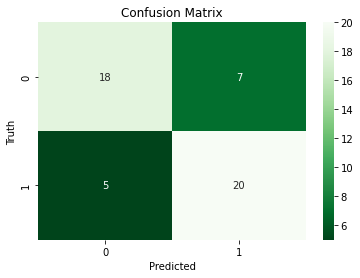

In [105]:
show_results_llama_zero()

## Few-shot

In [153]:
def read_responses_few_shot_llama(response):
    request_uuid = response["request_uuid"]
    ready = False
    while not ready:
        r = requests.get(f"{base_url}/get_result/{request_uuid}")
        try:
            response = r.json()
            ready = response['ready']

            if ready:
                print(f"Response for {request_uuid} is ready!")
                if response['generated_text'] is not None:
                    label = response['generated_text'].split('\n')[0].replace(" ", "")
                    if label == "negative":
                        label = 0

                    if label == "positive":
                        label = 1
                else:
                    label = 0

                answer = {
                    "generated_text": response['generated_text'],
                    "label": label
                }

                break

            # Wait 10 seconds before checking again
            time.sleep(10)
        except JSONDecodeError as ex:
            time.sleep(2)
            print(f"Trying {request_uuid} again!")

    return answer

In [154]:
def classify_few_shot_llama():
    responses = []
    for index, row in tqdm(df_data.iterrows(), total=df_data.shape[0]):
        text = row["text"]

        data = {
          "prompt":"""Answer with one word if the following review is positive or negative

          Example 1:

          Input: Wow. At first I thought who writes these things! 
          How hard is that choice between a man who offers you and your children wealth, 
          respectability and security as opposed to a husband who offers you only oppression, abuse, degradation and poverty. 
          However our choices are not always as clear cut cut as one would think. 
          Indeed the wealthy gentleman was all a woman could aspire to and yet... 
          the pull of her husband, her sexual desire for him was almost overwhelming. 
          What to do, what to do?? As a viewer you became as confused and misdirected as she was. 
          Anyway what I really came on this site to gush about was my admiration of the voice of the Engish, 
          I thought, although it is actually the voice of an Irish singer in the film. Looking him up 
          I find he is Glen Hansard, whom I had never heard of before that day. What a find. I am so grateful. 
          Wow, what a voice! What a day! Thank you BIFF!

          Output: positive
          ###
          Example 2:

          Input: Not only is this a very interesting exploration of Tourette's and how we react to people in our lives, 
          it has some of the most well-filmed views of a bleak northern winter landscape. 
          There's nothing pretty about this film, but it stays with the viewer.

          Output: positive
          ###
          Example 3:

          Input: Stewart is a Wyoming cattleman who dreams to make enough money to buy a small ranch in 
          Utah ranch\x85 His only real companion is his sidekick Ben Tatum, the great Walter Brennan\x85 
          To accomplish that, they drive the cattle clear to Alaska and on to Dawson, in Canadian territory, 
          where they sell them...Along the way they meet the man who runs the gold-crazy town 
          behind a dishonest lawman John McIntire... He attempts to steal them the herd... Later, in Dawson,
           McIntire and his gang reappear, this time interfering with Stewart's gold claim... 
           Captured by Mann's camera in the wonderful scenery of the Canadian Rockies, 
           Stewart is a thoughtful loner forced into violence by his need to get rid of the treacherous actions of a 
           corrupt entrepreneur robbing local miners of their claims\x85In this entertaining, beautiful Western, 
           Stewart has two leading ladies to struggle with: Ruth Roman, a bit too valuable to describe as a 
           sexy woman resisting the worst vicissitudes of the territory and the more docile, the French Canadian girl 
           Corinne Calvet who does create a nice portrait of a likable girl with the ability to form a judgment... 
           In spontaneous manner, Stewart is lost between the ostentatious saloon owner and the wife-candidate...

          Output: positive
          ###
          Example 4:

          Input: I remembered this show from when i was a kid. i couldn\'t remember too much about it,
           just a few minor things about the characters. for some reason i remembered it being really intense. 
           also it was on really really early in the morning up in PA. I finally, after looking around 
           the web for a long time, found an episode. the first episode no-less. Criminey! This show was so horrible. 
           it was obviously just made to show kids playing lazer tag and having a great time. 
           the show opens with bhodi li telling his mommy "my names not Christopher, 
           I\'m bhodi li-PHOTON WARRIOR!!!!!" we then are forced to watch kids playing lazer tag 
           to the song "foot loose". and not just a quick little bit, but the whole song. 
           ahhhhhhhhh my brain hurts just thinking about it. oh yeah, and as if i couldn\'t get 
           worse, you cant even see the laser beams from their guns. its like they\'re just running 
           around to the entire "foot loose" song. later on, after bhodi goes up into space or where-ever, 
           they have a crappy laser gun fight to the Phil Collins song "su-su-sudio." ah, 
           trust me, you don\'t want to know the rest. what can i say......THE LIGHT SHINES!!!!!!!!!!!

           Output: negative
           ###
           Example 5:

           Input: The Good: I liked this movie because it was the first horror movie 
           I\'ve seen in a long time that actually scared me. The acting wasn\'t too bad, 
           and the "Cupid" killer was believable and disturbing.
           The Bad: The story line and plot of this movie is incredibly weak. 
           There just wasn\'t much to it. The ways the killer killed his victims was very horrifying and disgusting. 
           I do not recommend this movie to anyone who can not handle gore.
           Overall: A good scare, but a bad story.** out of *****

           Output: negative
           ###
           Example 6:

           Input: I\'m a big mark for the music of Neil Young, 
           and with that and the glowing praise the film received in many alt-indie press circles, 
           hit the first showing of Greendale I could find. 
           My excitement was short-lived, as this turgid storyline and weak lyrical momentum left most 
           filmgoers either asleep or disappointed.Neil says the film started as a soundtrack, 
           and the characters came to life so much that they just filmed the soundtrack. 
           Not the best way to craft a story. No character really has an arc, and when "significant" events do happen, 
           the viewer doesn\'t cared, because film technique annoyance levels are so high by that point. 
           The film is all song, and to that end, the characters on end mouth the lyrics as 
           they\'re sung...the technique works for the first stanza it is done, and is grating on the nerves after that. 
           It doesn\'t feel real or fake, it just feels unwelcome.Terrible acting, 
           with characters finding one mood and playing all of it. Poor lighting at times. 
           The only kudos I can give the film are in regard to several scenes shot as newscast, 
           but the technique is so used in cinema today that this film did little to further it. 
           An alright soundtrack, but nothing I\'m quick to buy. A bad film.

           Output: negative
          ###
           Example 7: 

           Input: {}

           Output:
            """,
          "temperature": 0.0,
          "top_p": 1,
          "max_length": 250
        }

        data['prompt'] = data['prompt'].format(text)

        req = requests.post(f"{base_url}/complete", json=data)

        if req.ok:
            response = req.json()
            answer = read_responses_few_shot_llama(response)
            responses.append(answer)

            with open(f'{base_path}data/responses_llama_few.pickle', 'wb') as f:
                pickle.dump(responses, f)

    return responses

In [162]:
def show_results_llama_few():
    with open(f'{base_path}data/responses_llama_few.pickle', 'rb') as f:
        responses_llama_zero = pickle.load(f)
        
    preds = []
    for answer in responses_llama_zero:
        if str(answer["label"]).isnumeric():
            label = int(answer["label"])
        else:
            label = 0

        preds.append(label if label < 2 else 0)

    labels = df_data["label"].values
    
    print(classification_report(labels, preds, target_names=target_names))
    
    ax = sns.heatmap(confusion_matrix(labels, preds), cmap='Greens_r', annot=True, fmt='d')
    _ = ax.set(xlabel='Predicted', ylabel='Truth', title='Confusion Matrix')

In [156]:
responses = classify_few_shot_llama()

  0%|          | 0/50 [00:00<?, ?it/s]

Response for a45d44ff-6838-459b-80cd-208dd3588860 is ready!
Response for ce700a51-82f0-41fd-a75f-86c621cd0640 is ready!
Response for de576558-0394-42a8-b5b4-ce5f847e1211 is ready!
Response for 08364275-cb33-4bbb-bdd9-844186b03336 is ready!
Response for 3b4f533b-b1ad-448d-93a1-335195fa4c52 is ready!
Response for 5de77aaf-c766-4638-86bf-5e76a45e8948 is ready!
Response for da99c983-3107-407e-a01c-ab69d7a5f13f is ready!
Response for 6154a10a-3379-4c9f-8845-ffbacd3c521f is ready!
Response for a847a97d-83cb-4bac-bb5f-8cf22f6c1c9d is ready!
Response for 24b53e48-71d7-4a27-bdb6-7b40b61621f1 is ready!
Response for 0aca6ed0-ad2a-48b0-a612-7257dd032cb5 is ready!
Response for 2b57fc03-37f0-477e-b722-a8281c0781d2 is ready!
Response for 272005c5-f877-4e80-a0d1-3fe6ed0dea71 is ready!
Response for 808726ad-5a23-4c5c-9e58-df1dae816303 is ready!
Trying d3fba366-37f7-40db-802d-189848f0e548 again!
Response for d3fba366-37f7-40db-802d-189848f0e548 is ready!
Response for eee8b8c0-2cd1-47de-abc7-0ad9af538166

              precision    recall  f1-score   support

    Negative       0.88      0.84      0.86        25
    Positive       0.85      0.88      0.86        25

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50



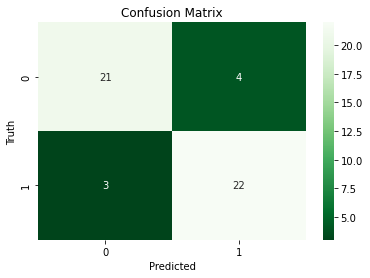

In [163]:
show_results_llama_few()

In [129]:
# text = "A mirian vai lucrar mais que o vencerdor do só em hora extra que ela tá fazendo kkk"
text = "If I could go back, even as an adult and relive the days of my Summer's spent at camp...I would be there so fast. The Camps I went to weren't even this great. They were in Texas where the mosquitoes actually carry people off but we had horses and fishing. The movie cinematography was astounding, the characters funny and believable especially Perkins, Pollack and Arkin. Sam Raimi's character and sub-antics were priceless. So who ever thought this movie was lame...I have deep pity for because they can't suspend their disbelief long enough to imagine camp life again as an adult or they never went as kids. The whole point was that these people had an opportunity to regress and become juvenile again and so they did at every opportunity. I wish I could. It was funny, intelligent, beautifully scripted, brilliantly cast and the artistry takes me back so I want to watch it over and over just for the scenery even. Sorta like Dances with Wolves and LadyHawk...good movies but the wilderness becomes a character as much as the actors. Rent it, see it, buy it and watch it over and over and over...never gets old. ;0)"


# data = {
#       "prompt":"""Answer with one word if the following review is positive or negative

#       Example 1:

#       Input: There are bad movies and then there are movies which are even worst. Saw is just that.<br /><br />The movie is simply bad on all points. The plot, the acting, the camera work, the music and everything else is absolutely terrible and I cannot begin to comprehend how such trash made it to the big screen.<br /><br />The simple fact is that Saw is riddled with plot holes. The beginning is enticing and leaves much to be expected but it does not hold up and the plot becomes absolutely ridiculous and absurd. The film is not creative and will not leave you with a single bit of credibility. People that claim that this movie is gory, violent, sadistic and scary are sissy girls who have nightmares after watching CSI because it is far from that.<br /><br />So I am warning you know, do not attempt to watch this if you have any form of intellect, because you will be disappointed. A true bore and a mediocre film as can be.

#       Output: negative
#       ###
#       Example 2:

#       Input: It\'s a shame that they didn\'t trust the original enough to build on it. <br /><br />But "RoboCop 2" takes the great ideas, imagination and characters of the original and replaces them with all the stereotypes that sequels have to offer.<br /><br />The beginning commercial was cute and so was the scene that follows (reminiscent of the beginning in "Guys and Dolls"!) but aside from a flash of thought here and there, this is one film that is a slow, dirty slog down into the middle of nowhere.<br /><br />Ideas are introduced then dropped, interesting characters from the original hardly get any screen time here, most of the new characters (Cain, Juliette Faxx) are so boring that they wouldn\'t hold up no matter what the movie, and then there\'s the tone.<br /><br />In the Blessed Original, Paul Verhoeven knew how to direct with the kind of attitude where if you cranked up the attitude and the sensibility of a good pulp comic, even the most repellent violence would be entertaining. Kershner (although he DID direct a "Star Wars" sequel) doesn\'t. And scene after scene either makes you cringe, look away or just tune it out altogether.<br /><br />And what\'s with RoboCop?? HE should be the main thing here, right? But there\'s whole scenes where he doesn\'t even show up, and what scenes he is in are so half-thought and shakily written that you don\'t know or care if he\'s part-human or part-cyborg - since he\'s all-boring.<br /><br />Never have I seen such a rapid fall from grace. Why does Hollywood make such bad sequels? On purpose? Why; did the film-makers have a bet going?<br /><br />Only one star for "RoboCop 2"; the FX are good but the story doesn\'t even try to match them.

#       Output: negative
#       ###
#       Example 3:

#       Input: As the number of Video Nasties I\'ve yet to see dwindles, this little pile of garbage popped up on my "to rent" list when I saw it was available.<br /><br />The premise involves a fashion model or something being kidnapped and taken into the jungle to be held for ransom by a motley crew of idiots. Some other goof gets hired to bring her back and is given a sack of money to use as a bargaining chip, though if he returns with the girl and all the money, he gets a significant cut. He\'s brought a helicopter and pilot with him and, wow, that pilot is one of the worst actors EVER! Granted, they are all totally terrible and the dubbing will make you cry blood. After stealing away into the jungle, we learn that nearby is a cannibal cult whose flesheating earthbound god wanders the woods like a human King Kong looking for tribeswomen to ravage and devour. Now, this fellow is just a naked guy with some of the worst makeup ever, ping-pong balls for eyes and that\'s pretty much it. His growls and groans are an everpresent feature on the soundtrack, and I found myself muting much of those scenes.<br /><br />Oh, did I forget to mention the almost constant nudity? This is probably the main reason this film was banned, though there is one specific scene, about one second long, where the god attacks a girl and pulls her guts out, but it\'s not a redeeming factor for gore fans. Also, Jess Franco goes beyond the usual T and A and shows lengthy close-ups of female genitals, and, sadly, male as well. So, if you want "fair" in terms of exploitation, you got it.<br /><br />I can\'t recommend this trash to anyone. It\'s not even the good bad movie. It\'s just atrociously padded trash that only a Video Nasty fan will probably view and even then, if you are making your way through the list, leave this for the very last. If you watch it first, you may get the notion that this is the norm for the list, which is certainly not true.

#       Output: negative
#       ###
#       Example 4:

#       Input: First, the obvious\x97as a cop drama crossed with a funny melodrama, QUAY \x85 is disconcerting ,straightly independent and a menace to banality. Jouvet's aplomb is put to good use in a tough cop performance immediately noticeable by its vigor and exuberant force; his Antoine is not so much a man of intellect, but a man of vast life experience and earthly instinct. QUAY \x85 is not subversive in the sense that today's (and already yesterday's ) philistines enjoy using the word. It is Clouzot's most playful hour. He tended to adapt Steeman's books in a satiric note. (It's said that Clouzot was a big reader of detective novels.) As a director, Clouzot's firm hand is successful. <br /><br />It is not a mystery or a thriller,but a satirical look at a Parisian couple and at the police's proceedings. Those accustomed with Clouzot's masterpiece LES DIABOLIQUES might find slightly disconcerting the multiplicity of things, styles, elements in QUAY \x85.Here Clouzot speaks about many things, about a couple, and a hidden love story (Simone Renant's for Blier),about the entertainment's world and about old spinsters, about police techniques and an old bitter cop with a boy to raise, etc.. There is a note of exuberance\x97not only in Jouvet's performance, but also in the film's conception. <br /><br />Quay is a realistic crime drama made as a satire. It offers an outstanding performance by Jouvet as a tough police inspector. Antoine is an old cop with an adventurous past (he fought in Africa ,but did not climb the ranks' stair because of his independent behaviors); he lives with his son, a schoolboy; at work, Antoine is tough and merciless, an able inspector, bitter, intelligent and harsh. It is a role of great gusto, very picturesque. Jouvet composed his character of several defining traits\x97his clothes, his expression, his funny accent, his brutality, and that mocking air \x85.Antoine is not made to look more clever than plausible; when he interrogates Blier, Antoine makes mistakes ,and his talent is presented like the talent we meet in real life\x97mixed with errors and lacunae and defects. Antoine's talent is one that comes also from experience, from daily observation\x97it's not the almost supernatural _divinatory genius of almost all the famous detectives.<br /><br />QUAY \x85 is multifaceted\x97it is a realistic crime drama, and also a satire and a melodrama. One can consider it among the first _filmic forays into the legendary toughness of the French police. Long ago Eastwood's and Wayne's harsh cops, there was Antoine. <br /><br />The title is interesting, suggesting that this is a movie about the police, not about a case or a mystery. <br /><br />As craftsmanship, Clouzot was perhaps the best and sharpest in France (in the way that Welles was). QUAY \x85 is very true to Clouzot's nature\x97a sardonic comic, sharp observations, much psychology, sharp, unsparing irony. The man was first\x97class when he filmed something\x97he knew what to shoot, what to choose\x97see the introductory scenes of this film, with Jenny Lamour's great stage success. Each scene is memorably, _exemplarily shot. Clouzot's technical, stylistic aptitudes were amazing. His style is inventive, satirical, sharp, extremely limpid, ingenious. <br /><br />Jouvet's style was exuberant, powerful, vehement. (Some disliked it precisely for these features. As he had been a great stage actor, his movie style was deemed as too theatrical, etc..) His Antoine is a fine example of what was meant by composing a role, by a composition. <br /><br />Jouvet had a very peculiar physiognomy\x97much like a menacing bird of prey\x97somewhat like Van Cleef\x97yet much subtler, nobler and more intelligent and distinguished. Jouvet had this predatory, ferocious air, and it is useful here, as he performs an old tough cop. One of QUAY \x85's sides is that it is a Jouvet recital. He is immediately recognizable, identifiable by the quality of his play (I see that many, watching this flick, do not know it is a Jouvet movie\x97which is an astounding quality in itself). <br /><br />Fresnay and Jouvet are the two French actors that I admire the most; the first one was revealed to me by a Renoir drama (the famous one), while Jouvet by a Carné comedy. I was charmed to see that Clouzot gave leading roles to both of them.<br /><br />To end, a word about Steeman; he wrote the novel used by Clouzot (who had previously adapted another Steeman novel, as a Fresnay comedy). Steeman was an old school mystery writer, in the Wallace vein. He became quickly outdated with the new hardboiled fashions. When I was 11 I have read one of his thrillers, and liked it much.

#       Output: positive
#       ###
#       Example 5:

#       Input: Young Elijah Wood and Joseph Mazzello are outstanding in this excellent film about two boys who have promised to "take care of their mother," and how they cope when their new stepfather begins beating the younger boy. The supporting cast around the boys is top-notch as well. The script really gets inside the mind and heart of an imaginative child. It\'s hard to believe Wood could grow up to look anything like Tom Hanks, but that\'s nothing new in Hollywood. That\'s honestly my only criticism of the film.

#       Output: positive
#       ###
#       Example 6:

#       Input: Okay, so Ghoulies 4 is kind of bad. And it doesn\'t really even have the ghoulies in it. And the acting is bad. The storyline is stupid. But I forget to mention how funny this film is. It is so campy, and so ridiculous it is too fun not to enjoy. There are only 2 ghoulies in the movie, and they don\'t really seem to be in relation with the Ghoulies in the other film. But they are pretty funny. And funny thing, that Jonathon Graves returns for this one. If you saw the first, he was a character in that. In my opinion, this is better than the first. There are some classic scenes and some classic lines, one which is in a grocery store. "Attention K-Mart Shoppers!" Watch this if you enjoy bad movies. It\'s so bad it is good. And did I mention Barbara Alyn Woods is hot?

#       Output: positive
#       ###
#       Example 7: 
       
#       Input: {}

#       Output:
#       """,
#       "temperature": 0.0,
#       "top_p": 1,
#       "max_length": 250
#     }

data = {
  "prompt":"""Answer with one word if the following review is positive or negative

  Example 1:

  Input: Wow. At first I thought who writes these things! 
  How hard is that choice between a man who offers you and your children wealth, 
  respectability and security as opposed to a husband who offers you only oppression, abuse, degradation and poverty. 
  However our choices are not always as clear cut cut as one would think. 
  Indeed the wealthy gentleman was all a woman could aspire to and yet... 
  the pull of her husband, her sexual desire for him was almost overwhelming. 
  What to do, what to do?? As a viewer you became as confused and misdirected as she was. 
  Anyway what I really came on this site to gush about was my admiration of the voice of the Engish, 
  I thought, although it is actually the voice of an Irish singer in the film. Looking him up 
  I find he is Glen Hansard, whom I had never heard of before that day. What a find. I am so grateful. 
  Wow, what a voice! What a day! Thank you BIFF!

  Output: positive
  ###
  Example 2:

  Input: Not only is this a very interesting exploration of Tourette's and how we react to people in our lives, 
  it has some of the most well-filmed views of a bleak northern winter landscape. 
  There's nothing pretty about this film, but it stays with the viewer.

  Output: positive
  ###
  Example 3:

  Input: Stewart is a Wyoming cattleman who dreams to make enough money to buy a small ranch in 
  Utah ranch\x85 His only real companion is his sidekick Ben Tatum, the great Walter Brennan\x85 
  To accomplish that, they drive the cattle clear to Alaska and on to Dawson, in Canadian territory, 
  where they sell them...Along the way they meet the man who runs the gold-crazy town 
  behind a dishonest lawman John McIntire... He attempts to steal them the herd... Later, in Dawson,
   McIntire and his gang reappear, this time interfering with Stewart's gold claim... 
   Captured by Mann's camera in the wonderful scenery of the Canadian Rockies, 
   Stewart is a thoughtful loner forced into violence by his need to get rid of the treacherous actions of a 
   corrupt entrepreneur robbing local miners of their claims\x85In this entertaining, beautiful Western, 
   Stewart has two leading ladies to struggle with: Ruth Roman, a bit too valuable to describe as a 
   sexy woman resisting the worst vicissitudes of the territory and the more docile, the French Canadian girl 
   Corinne Calvet who does create a nice portrait of a likable girl with the ability to form a judgment... 
   In spontaneous manner, Stewart is lost between the ostentatious saloon owner and the wife-candidate...

  Output: positive
  ###
  Example 4:

  Input: I remembered this show from when i was a kid. i couldn\'t remember too much about it,
   just a few minor things about the characters. for some reason i remembered it being really intense. 
   also it was on really really early in the morning up in PA. I finally, after looking around 
   the web for a long time, found an episode. the first episode no-less. Criminey! This show was so horrible. 
   it was obviously just made to show kids playing lazer tag and having a great time. 
   the show opens with bhodi li telling his mommy "my names not Christopher, 
   I\'m bhodi li-PHOTON WARRIOR!!!!!" we then are forced to watch kids playing lazer tag 
   to the song "foot loose". and not just a quick little bit, but the whole song. 
   ahhhhhhhhh my brain hurts just thinking about it. oh yeah, and as if i couldn\'t get 
   worse, you cant even see the laser beams from their guns. its like they\'re just running 
   around to the entire "foot loose" song. later on, after bhodi goes up into space or where-ever, 
   they have a crappy laser gun fight to the Phil Collins song "su-su-sudio." ah, 
   trust me, you don\'t want to know the rest. what can i say......THE LIGHT SHINES!!!!!!!!!!!

   Output: negative
   ###
   Example 5:

   Input: The Good: I liked this movie because it was the first horror movie 
   I\'ve seen in a long time that actually scared me. The acting wasn\'t too bad, 
   and the "Cupid" killer was believable and disturbing.
   The Bad: The story line and plot of this movie is incredibly weak. 
   There just wasn\'t much to it. The ways the killer killed his victims was very horrifying and disgusting. 
   I do not recommend this movie to anyone who can not handle gore.
   Overall: A good scare, but a bad story.** out of *****

   Output: negative
   ###
   Example 6:

   Input: I\'m a big mark for the music of Neil Young, 
   and with that and the glowing praise the film received in many alt-indie press circles, 
   hit the first showing of Greendale I could find. 
   My excitement was short-lived, as this turgid storyline and weak lyrical momentum left most 
   filmgoers either asleep or disappointed.Neil says the film started as a soundtrack, 
   and the characters came to life so much that they just filmed the soundtrack. 
   Not the best way to craft a story. No character really has an arc, and when "significant" events do happen, 
   the viewer doesn\'t cared, because film technique annoyance levels are so high by that point. 
   The film is all song, and to that end, the characters on end mouth the lyrics as 
   they\'re sung...the technique works for the first stanza it is done, and is grating on the nerves after that. 
   It doesn\'t feel real or fake, it just feels unwelcome.Terrible acting, 
   with characters finding one mood and playing all of it. Poor lighting at times. 
   The only kudos I can give the film are in regard to several scenes shot as newscast, 
   but the technique is so used in cinema today that this film did little to further it. 
   An alright soundtrack, but nothing I\'m quick to buy. A bad film.

   Output: negative
  ###
   Example 7: 

   Input: {}

   Output:
    """,
  "temperature": 0.0,
  "top_p": 1,
  "max_length": 250
}

data['prompt'] = data['prompt'].format(text)

req = requests.post(f"{base_url}/complete", json=data)

if req.ok:
    response=req.json()

In [141]:
request_uuid=response["request_uuid"]
ready = False
answers = []
while not ready:
    r = requests.get(f"{base_url}/get_result/{request_uuid}")
    response = r.json()
    ready = response['ready']

    if ready:
        label = response['generated_text'].split('\n')[0].replace(" ", "")
        if label == "negative":
            label = 0

        if label == "positive":
            label = 1

        answer = {
            "generated_text": response['generated_text'],
            "label": label
        }

        print(label)
        answers.append(answer)
        break

    # Wait 10 seconds before checking again
    time.sleep(10)

1
